Author: Abdulrahman Altahhan, 2024.

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Lesson 16: RL on Robotics

**Learning outcomes**
1. understand how to create a simple Robot environment that links to Gazebo
1. understand how to deal with the simulated environment in a grid world fashion
1. appreciate the intricacy of applying RL to the robotics domain
1. build on previous concepts to come up with a suitable solution to a problem at hand
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence
1. understand how to combine deep reinforcement learning with deep learning to create a powerful framework that allows automatic agent learning by observation or self-play.
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence for difficult problems that involve image processing and reinforcement learning


**Reading**:
We cover applications of RL on robotics based on previouse units which you can refere to.

In this notebook, we deal with how to set up a robot environment class that can handle the publish-subscribe on topics and deal with services in ROS. We must have ROS and Gazebo installed and set up on our machine. The code is a starting point and is not fully developed. You will need to write the necessary functionality to address a specific requirement. The main idea of tackling robotics applications in a Jupyter notebook is to utilise the provided infrastructure and libraries of code we covered in earlier units.

# Instructions for running Experiments on Azure VM
The VM usage limit is set to 40 hours. Please turn off the machine when not using it to preserve your time. The VM is not set to disconnect you automatically so that you can leave it training the robot continuously for assessment 2.

Please turn off the screen save and screen lock in Xfce(Applications->Settings->Light Locker) as it may cause the machine to become not responsive, which in turn, causes Azure to stop it automatically.

If the VM becomes corrupted for some reason, then you can reimage it by going to Azure Lab page and selecting the three dots, then reimage. **Reimage will reset the VM to its initial settings but it causes all data you have on the machine to be lost.** You are advised to backup your data, you may want to use OneDrive or other backup methods.

**Note If Gazebo stops for any reason, the provided code has a try-except statement (in lesson 4 Monte Carlo) that you can activate (comment in). It allows you to continue training even if the robot becomes not responsive without having to restart the experiment.**

If you are running out of time, please let your tutor know in advance and they will try to increase your VM time allowance.

## Turtlebot3 
Install [turtlebot3](https://emanual.robotis.com/docs/en/platform/turtlebot3/quick-start/#install-dependent-ros-packages-1) packages. If you are in our VM, they would have been already installed.

## More realistic Simulation: Running Gazebo
You will need to launch a gazebo environment with Turtlebot3 in it. So long as the /scan(LaserScan), /odom (Odometry) and /cmd_vel(Twist) topics are available, the environment should work fine. Our target is to build an environment that will allow us to use the algorithms we developed in earlier units directly.

To launch an environment, you should open a terminal and run the following command

ros2 launch turtlebot3_gazebo turtlebot3_house.launch

Note that you cannot do that here because that will block the notebook from executing other code. 
You must select restart your notebook kernel, ex. Kernel-> Restart and Run ALL, whenever you want to re-establish a connection with the environment.


In [1]:
%matplotlib inline

In [2]:
import rclpy as ros
from rclpy.node import Node

from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from sensor_msgs.msg import LaserScan
from std_srvs.srv import Empty
from gazebo_msgs.srv import SpawnModel

import numpy as np
from numpy import Inf
from random import randint
from math import atan2, atan, pi
import matplotlib.pyplot as plt
ros.init()

In [3]:
# !export PATH="home/rl/.local/bin:/opt/ros/humble/share:$PATH"
# !python3 -c "import rclpy as ros; ros.init()"

## Moving the robot(Actions)
We start by controlling the robot only

Go to /opt/ros/humble/share/turtlebot3_gazebo/models/turtlebot3_burger/model.sdf and adjust the <update_rate>30</update_rate> to <update_rate>5</update_rate> for the odomotry turtlebot3_diff_drive. This will change its frequency from 30 to 5 so that it aligns with the scanner frequency.

In [4]:
def name(): return 'node'+str(randint(1,1000))

In [5]:
class Env(Node):

# initialisation--------------------------------------------------------------
    # frequency: how many often (in seconds) the spin_once is invoked, or the publisher is publishing to the /cmd_vel
    def __init__(self, name=name(), 
                 freq=1/20, n=28, 
                 speed=.5, θspeed=pi/5, 
                 rewards=[30, -10, 0, -1],
                 verbose=False):
        super().__init__(name)
        
        self.freq = freq
        self.n = n
        
        self.speed = speed
        self.θspeed = round(θspeed,2)
        
        self.robot = Twist()
        self.rewards = rewards
        self.verbose = verbose

        # do not change----------------------------------------------------
        self.x = 0 # initial x position
        self.y = 0 # initial y position
        self.θ = 0 # initial θ angle
        self.scans = np.zeros(60) # change to how many beams you are using
        self.t = 0
        
        self.tol = .6  # meter from goal as per the requirement (tolerance)
        self.goals =  [[2.0, 2.0], [-2.0, -2.0]]
        # -----------------------------------------------------------------
        
        self.controller = self.create_publisher(Twist, '/cmd_vel', 0)
        self.timer = self.create_timer(self.freq, self.control)

        self.scanner = self.create_subscription( LaserScan, '/scan', self.scan, 0)
        self.odometr = self.create_subscription( Odometry, '/odom', self.odom, 0)
        
        self.range_max = 3.5
        self.range_min = .28               # change as you see fit
       

        # establish a reset client 
        self.reset_world = self.create_client(Empty, '/reset_world')
        while not self.reset_world.wait_for_service(timeout_sec=2.0):
            print('world client service...')


        # compatibility----------------------------------------------
        nturns = 15 # number of turns robot takes to complete a full circle
        resol = speed/2
        
        θresol = 2*pi/nturns
        dims = [4,4]
        self.xdim = dims[0]  # realted to the size of the environment
        self.ydim = dims[1]  # realted to the size of the environment
        
        self.resol = round(resol,2)
        self.θresol = round(θresol,2)
        
        self.cols  = int(self.xdim//self.resol) +1   # number of grid columns, related to linear speed
        self.rows  = int(self.ydim//self.resol) +1   # number of grid rows,    related to linear speed
        self.orts  = int(2*pi//self.θresol)     +1   # number of angles,       related to angular speed

        self.nC = self.rows*self.cols              # Grid size
        self.nS = self.rows*self.cols*self.orts # State space size
        self.nA = 3
        

        self.Vstar = None # for compatibility
        # --------------------------------------------------------------- 
        # self.rate = self.create_rate(30)
        self.reset()
        
        print('speed  = ', self.speed)
        print('θspeed = ', self.θspeed)
        print('freq   = ', self.freq)

# sensing--------------------------------------------------------------
    # odometry (position and orientation) readings
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)
        self.y = round(odoms.pose.pose.position.y, 1)
        self.θ = round(self.yaw(odoms.pose.pose.orientation),2) 
        self.odom = np.array([self.x, self.y, self.θ])
        if self.verbose: print('odom = ',  self.odom )
    
    # laser scanners readings
    def scan(self, scans):
        self.scans = np.array(scans.ranges)
        self.scans[scans==Inf] = self.range_max
        # if self.verbose: print('scan = ', self.scans[:10].round(2))
        if self.verbose: print('scan = ', np.r_[self.scans[-5:], self.scans[:5]].round(2))
        
    # converting to the quaternion self.z to Euler
    # see https://www.allaboutcircuits.com/technical-articles/dont-get-lost-in-deep-space-understanding-quaternions/#
    # see https://eater.net/quaternions/video/intro
    
    def yaw(self, orient):
        x, y, z, w = orient.x, orient.y, orient.z, orient.w
        yaw = atan2(2.0*(x*y + w*z), w*w + x*x - y*y - z*z)
        return yaw if yaw>0 else yaw + 2*pi # in radians, [0, 2pi]
    
    # angular distance of robot to a goal.............................................
    def θgoal(self, goal):
        xgoal, ygoal = self.goals[goal] 
        x, y  = self.x, self.y
        θgoal = atan2(abs(xgoal-x), abs(ygoal-y)) # anglegoal
        # if θgoal<=0  θgoal += 2*pi
        return round(θgoal, 2) # in radians, [0, 2pi]
    
    # Eucleadian distance of robot to nearest goal......................................   
    def distgoal(self):
        dists = [Inf, Inf]        # distances of robot to the two goals
        for goal, (xgoal, ygoal) in enumerate(self.goals):
            dists[goal] = (self.x - xgoal)**2 + (self.y - ygoal)**2
            
        dist = min(dists)         # nearest goal distance
        goal = dists.index(dist)  # nearest goal index
        
        if self.verbose: print('seeking goal ____________________', goal)
        return round(dist**.5, 2), goal
    
    # robot reached goal ...............................................................
    def atgoal(self):
        tol, x, y = self.tol,  self.x, self.y
        atgoal = False
        for xgoal, ygoal in self.goals:
            atgoal = xgoal + tol > x > xgoal - tol  and  \
                     ygoal + tol > y > ygoal - tol
            
            if atgoal: print('Goal has been reached woohoooooooooooooooooooooooooooooo!!'); break
        return atgoal

    # robot hits a wall...................................................................
    def atwall(self, rng=5):
        # check only 2*rng front scans for collision, given the robot does not move backward
        return np.r_[self.scans[-rng:], self.scans[:rng]].min() < self.range_min 
        #return self.scans.min()<self.range_min
        
    # reward function to produce a suitable policy..........................................
    def reward(self, a, imp=2):
        stype = [self.atgoal(), self.atwall(), a==1, a!=1].index(True)
                
        dist, goal = self.distgoal()
        θgoal = self.θgoal(goal)

        # get angular distance to reward/penalise robot relative to its orientation towards a goal
        θdist = abs(self.θ - θgoal)
        if goal==1: θdist -= pi
        θdist = round(abs(θdist),2)

        reward = self.rewards[stype] 
        if stype: reward -= imp*(dist+θdist) 
        
        if self.verbose: 
            print('reward components=', 
                  'Total reward=', reward, 
                  'state reward=', self.rewards[stype],
                  'goal dist=', dist, 
                  '|θ-θgoal|=', θdist)
                #   'θrobot=', self.θ, 
                #   'θgoal =', θgoal, 
        
        # reset without restarting an episode if the robot hits a wall
        if stype==1: self.reset() 

        return reward, stype==0, stype==1

# State representation-------------------------------------------------
   # change this to generate a suitable state representation
    def s_(self):
        
        self.xi = int((self.x+self.xdim/2)//self.resol)     # x index = col, assuming the grid middle is (0,0)
        self.yi = int((self.y+self.ydim/2)//self.resol)     # y index = row, assuming the grid middle is (0,0)
        
        # pi/2 to be superficially resilient to slight angle variation to keep θi unchanged
        self.θi = int((self.θ+pi/2)%(2*pi)//self.θresol)
        
        self.si = self.xi + self.yi*self.cols     # position state in the grid
        self.s = self.nC*(self.θi) + self.si      # position state with orientation
        if self.verbose: print('grid cell= ', self.si, 'state = ', self.s)
        return self.s 


# Control--------------------------------------------------------------    
    def spin_n(self, n):
        for _ in range(n): ros.spin_once(self)
            
    def control(self): 
        self.controller.publish(self.robot) 
        
    # move then stop to get a defined action
    def step(self, a=1, speed=None, θspeed=None):
        if speed is None: speed = self.speed
        if θspeed is None: θspeed = self.θspeed

        self.t +=1
        if self.verbose: print('step = ', self.t)
        
        if  a==-1: self.robot.linear.x  = -speed  # backwards
        elif a==1: self.robot.linear.x  =  speed  # forwards
        elif a==0: self.robot.angular.z =  θspeed # turn left
        elif a==2: self.robot.angular.z = -θspeed # turn right

        # Now move and stop so that we can have a well defined actions  
        self.spin_n(self.n) if a==1 else self.spin_n(self.n//2)
        self.stop()

        reward, done, wall = self.reward(a)
        return self.s_(), reward, done, {}
        
    def stop(self):
        self.robot.linear.x = .0
        self.robot.angular.z = .0
        #  spin less so that we have smoother actions
        self.spin_n(self.n//8)

# reseting--------------------------------------------------------------
    def reset(self):
        print('resetting world..........................................')
        # to ensure earlier queued actions are flushed, there are better ways to do this
        for _ in range(1): self.reset_world.call_async(Empty.Request())
        for _ in range(2): self.step(a=1, speed=0.001)  # move slightly forward to update the odometry to prevent repeating an episode unnecessary
        for _ in range(1): self.reset_world.call_async(Empty.Request())
        
        return self.s_()

    # for compatibility, do not delete
    def render(self, **kw):
        pass

Ok, let us now test our little environment, to do so, open a terminal and launch the simple environment be executing the following command:

<code> ros2 launch turtlebot3_gazebo turtlebot3_simple.launch.py </code>

To make the testing smoother, you can right-click Gazebo and keep the window on top.
You can also press ctrl+R to reset the environment.

## Rotational and Translational Calibration

Let us calibrate the rotational and translational movements of our robot settings. The idea here is to be able to get a consistent behaviour where a robot can consistently complete a full circle in a specified number of times *most of the times*. This is a trial and error process, we usually need to experiment with different settings, bearing in minde the accuracy and efficiency of the robot training that will take place later.

The frequency plays an important role as it specifies how many times the velocity changes commands are going to be executed per seconds. This is via our subscription to the /cmd_vel topic and the create_timer() function of the Node class.
The second important factor is the number of times the spin_once() is going to be executed. Spining a few times after publishing a command helps stablise the behaviour and gives us more consistency because it helps flush any delayed execution as well as any delayed subscription due to the robot hardware limitation which is simulated to an extent in Gazebo.

### Rotation in place to form a full $2\pi$ circle
You could try to increase the θspeed but that will result in more slippage.
It is also possible to increase the speed of execution (rather that the speed of the robot) by playing with n which is the number of times a spin_once() is executed. You could also speed up the clock by increasing the hz (frequency) of execution.

In [6]:
hz = 20       # increase to speed up, default is 20, max 30 to speed up
n  = 28       # decrease to shorten the movements, default is 30, min 5 to speed up

env = Env(speed=.5, θspeed=pi/5, freq=1/hz, n=n, verbose=True)

resetting world..........................................
step =  1
scan =  [1.19 2.51 2.43 2.41 2.39 2.38 2.39 1.54 1.51 2.62]
odom =  [ 0. -0.  0.]
odom =  [0. 0. 0.]
odom =  [0. 0. 0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.22 2.53 2.45 2.39 2.37 2.37 2.4  1.54 1.51 2.62]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.22 2.53 2.45 2.39 2.38 2.38 2.4  1.52 1.49 2.62]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
seeking goal ____________________ 0
reward components= Total reward= -7.24 state reward= 0 goal dist= 2.83 |θ-θgoal|= 0.79
grid cell=  144 state =  1011
step =  2
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.19 2.52 2.43 2.4  2.39 2.38 2.39 1.53 1.52 2.6 ]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan = 

In [7]:
def rotate_test(env):
    env.reset( )
    for _ in range(1+39):
        env.step(0)

# %time rotate_test(env)

### Translation calibration, moving in a straight line
You could try to increase the speed but that will result in bending.

In [8]:
def forward_test(env):
    env.reset( )
    # for _ in range(2): env.step(0)
    for _ in range(10):
        env.step()

# forward_test(env)

In [9]:
# env.reset()

### Manual solution (policy) to the given problem

In [10]:
def optimal_policy1(env):
    env.reset( )
    
    for _ in range(3): env.step(0)
    for _ in range(5): env.step()
    for _ in range(3): env.step(0)
    for _ in range(2): env.step()
    
# %time optimal_policy1(env)

In [11]:
def optimal_policy2(env):
    env.reset( )
    
    for _ in range(13): env.step(2)
    for _ in range(6): env.step()
    for _ in range(5): env.step(2)
    for _ in range(2): env.step()

# %time optimal_policy2(env)

# Applying an RL Algorithms to Train a Turtlebot3 to Autonomously Reach the Goals
Now let us apply Sarsa on this problem

In [12]:
from rl.rl import *

In [13]:
# env_slow = Env(speed=.5 , θspeed=pi/2, verbose=False) # slower more thorough
# env_fast = Env(speed= 1., θspeed=.75*pi, verbose=False) # useful for testing

In [14]:
# env = env_fast
# short max_t so that an episode does not take long
# sarsa = Sarsa(env=env, α=.1, max_t=200, episodes=300, seed=0, **demoGame()).interact()

### Resume Training and Extend training
If training intrrupted for any reason (including finishing the assigned number of episodes), you can resume it by passing resume=True to the interact() function.

In [15]:
# env.reset()


In [16]:
# sarsa.interact(resume=True)

In [17]:
# sarsa.episodes = 1000
# # sarsa.rewards=[100, -10, 0, -1]
# %time sarsa.interact(resume=True)

## Vectorised Environment
Let us now try to changed teh states from a number/index into vector.
We will simply utilise the laser scans. We can use them as is or try to turn them into some form of a hot encoding or tile coding. Below we show a simple implementaiton which you can build on. Note that we will import algorithms from RLv instead of RL so that we can use the vectorised linear model RL algorithms such Sarsa and Q_learning.

In [19]:
class vEnv(Env):
    def __init__(self, nscans=60, **kw):
        self.nF = nscans
        super().__init__(**kw)


    def s_(self):
        max, min = self.range_max, self.range_min
        φ = self.scans
        φ[φ==Inf] = max
        φ[φ==np.nan] = 0
        φ[φ<min] = 0
        φ = 1 - φ/max
        return  φ/φ.sum() 
    
    # def s_(self):
    #     nF, scans, range_max = self.nF, self.scans, self.range_max
    #     φ = np.r_[scans[-nF//2:], scans[:nF//2]]
    #     φ[φ==Inf] = range_max
    #     # φ[φ > range_max/2] = 0
    #     # φ[φ != 0] = 1
    #     # print(φ)
    #     return φ/φ.sum()

In [20]:
venv = vEnv(speed= .5, θspeed=pi/5, rewards=[30,-10,0,-1], verbose=True) # useful for testing

[WARN] [1715334431.685891644] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


resetting world..........................................
step =  1
odom =  [0. 0. 0.]
scan =  [1.23 2.52 2.44 2.4  2.38 2.38 2.4  1.53 1.52 2.63]
odom =  [0.   0.   6.28]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.19 2.49 2.44 2.4  2.36 2.39 2.41 1.56 1.52 2.6 ]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.21 2.51 2.44 2.39 2.38 2.39 2.38 1.55 1.5  2.61]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
seeking goal ____________________ 0
reward components= Total reward= -7.24 state reward= 0 goal dist= 2.83 |θ-θgoal|= 0.79
step =  2
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.19 2.52 2.44 2.4  2.38 2.39 2.38 1.53 1.5  2.63]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [

Now it is time to apply Sarsa on robotics! Note that this might not generate a useful policy yet. You must adjust the above code and tune your RL method hyperparameters.

In [ ]:
from rl.rlln import *

CPU times: user 35min 38s, sys: 1min 23s, total: 37min 2s
Wall time: 7h 53min 35s


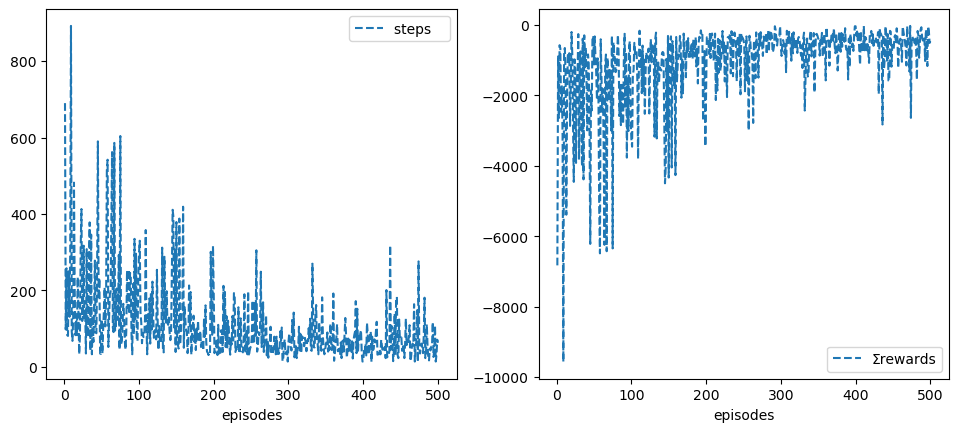

In [21]:
%time vsarsa = Sarsaλ(env=venv, α=.05, ε=.1, max_t=1000, episodes=500, seed=1, **demoGame()).interact()

CPU times: user 30min 2s, sys: 1min 9s, total: 31min 12s
Wall time: 7h 4min 40s


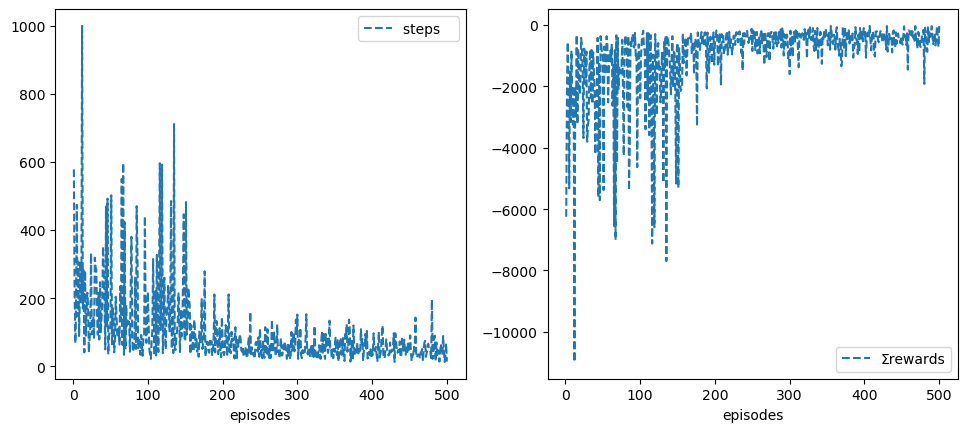

In [22]:
%time vtruesarsa = trueSarsaλ(env=venv, α=.05, ε=.1, max_t=1000, episodes=500, seed=1, **demoGame()).interact()

In [23]:
# venv.θspeed = pi/3 
# that means we are changing the env dynamics which is more challenging for the agent
# vsarsa.ε = .1
# vsarsa.dε= 1
# vsarsa.εmin

CPU times: user 30.8 s, sys: 1.42 s, total: 32.3 s
Wall time: 6min 31s


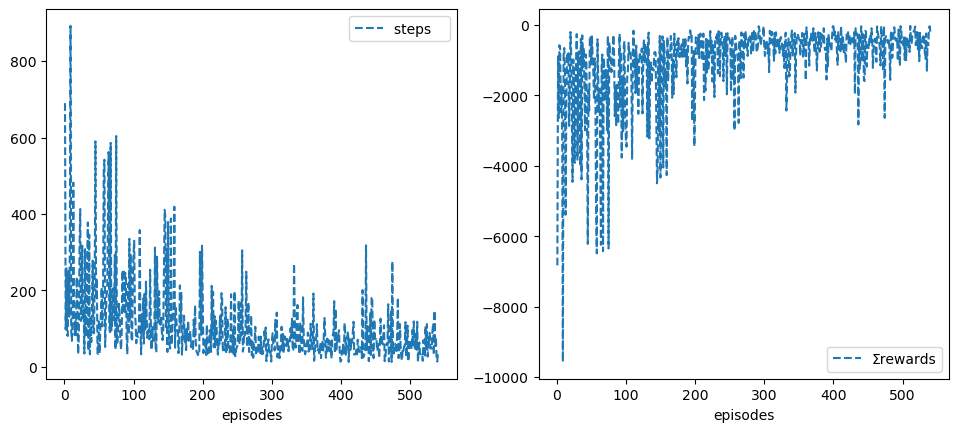

In [28]:
vsarsa.episodes = 540
# sarsa.rewards=[100, -10, 0, -1]
%time vsarsa.interact(env=venv, resume=True)

CPU times: user 1min 25s, sys: 3.76 s, total: 1min 29s
Wall time: 18min 5s


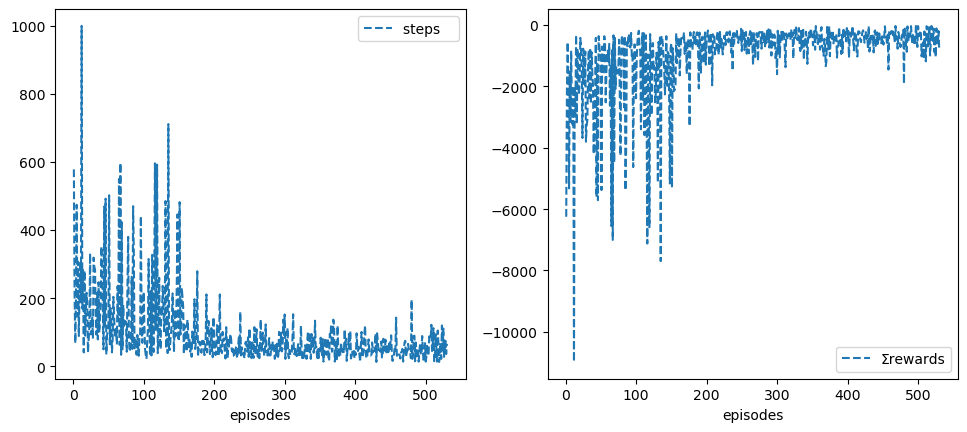

In [27]:
vtruesarsa.episodes = 530
# sarsa.rewards=[100, -10, 0, -1]
%time vtruesarsa.interact(env=venv, resume=True)

In [25]:
venv.reset()

resetting world..........................................
step =  116815
scan =  [0.23 0.24 0.28 0.28 0.12 0.12 0.12 0.15 0.17 0.18]
odom =  [2.3  1.6  0.57]
scan =  [1.2  2.52 2.43 2.39 2.38 2.37 2.41 1.54 1.51 2.62]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.19 2.52 2.45 2.4  2.39 2.39 2.4  1.54 1.51 2.6 ]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.2  2.51 2.44 2.39 2.38 2.4  2.39 1.54 1.52 2.61]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
seeking goal ____________________ 0
reward components= Total reward= -7.24 state reward= 0 goal dist= 2.83 |θ-θgoal|= 0.79
step =  116816
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
scan =  [1.22 2.52 2.43 2.39 2.39 2.39 2.41 1.54 1.52 2.6 ]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
odom =  [ 0. -0.  0.]
od

array([0.01292713, 0.01281209, 0.0227836 , 0.02324465, 0.01027762,
       0.00855598, 0.00619121, 0.00852212, 0.01901032, 0.01732261,
       0.01271966, 0.01092166, 0.0123869 , 0.01278423, 0.01308601,
       0.02420145, 0.02379162, 0.02363867, 0.02289693, 0.02216109,
       0.02112418, 0.0060394 , 0.0024645 , 0.00575699, 0.00831019,
       0.02626327, 0.02679824, 0.02755685, 0.02754739, 0.02787054,
       0.02779497, 0.02766693, 0.02734911, 0.01158986, 0.01050995,
       0.01039502, 0.01457711, 0.01629029, 0.00589362, 0.00818161,
       0.01017182, 0.02215024, 0.02146195, 0.01321665, 0.01336568,
       0.01321665, 0.01286833, 0.01212773, 0.01087723, 0.00950818,
       0.02127673, 0.02375081, 0.02529406, 0.02671511, 0.0276625 ,
       0.02650686, 0.01138107, 0.01230194, 0.01287275, 0.01305804],
      dtype=float32)

## Training Headless
To train more efficiently, turn off the gui in gazebo. To do so, go to the .launch file that you have launched gazebo with and comment out the follwoing lines:

       IncludeLaunchDescription(
           PythonLaunchDescriptionSource(
               os.path.join(pkg_gazebo_ros, 'launch', 'gzclient.launch.py')
           ),
       ),

Continue by adding more cells to address the requirements

[Back to TOC](IntroductionTOC.ipynb)